In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import yfinance as yf

from arch.compat.numba import jit

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

from enum import Enum
import math

In [2]:
class BetaType(Enum):
    NO = 1
    RAW = 2
    RETURNS = 3
    FILTERED = 4

In [3]:
DATE_FROM = '2015-01-01'
DATE_TO = '2017-12-31'
tickers = ['TSLA', 'AAPL', 'IBM', 'AMZN', 'MMM',
           'ABMD', 'ACN', 'APD', 'GOOGL', 'BLK']

INITIAL_CASH = 500000
FEE = 0.001
MAX_POSITION_PER_EQUITY = max(1. / len(tickers), 0.2)
MAX_POSITION_PER_EQUITY_PER_TRADE = max(1. / len(tickers), 0.05)
MAX_DRAWDOWN_PER_DAY = 0.005
MAX_DRAWDOWN_PER_WEEK = 0.02

In [4]:
BETA_TYPE = BetaType.FILTERED
BETA_LAG = 252
GARCH_LAG = 200
CORRELATION_MATRIX_LAG = 200
GARCH_REFIT_DELAY_DAYS = 30

In [5]:
MEAN_MODEL = "Constant"
VOL_MODEL = "Garch"
DISTRIBUTION_ = "Normal"

In [6]:
p_ = 2
o_ = 0
q_ = 2

In [7]:

def _find_best_model_params(TS: pd.Series):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(1, 5) # [1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(method='mle', trend='nc')
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return best_aic, best_order

In [8]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

In [9]:
def raw_adj_close_prices(ticker: str, date_from: str, date_to: str):
    prices = yf.download(ticker, date_from, date_to)
    prices.index = prices.index.to_period(freq='d')
    return prices['Adj Close']

In [10]:
def raw_adj_close_log_returns(prices: pd.Series):
    return np.log(prices).diff().fillna(0)

In [11]:
def beta(market: pd.Series, single_stock: pd.Series, lag: int = 252):
    return market.cov(single_stock, lag) / market.std(ddof=lag)

In [12]:
@jit
def arch_filtered_series(returns: pd.Series,
                         dist: str = 'Normal',
                         mean: str = 'HARX',
                         vol: str = 'Garch',
                         lag: int = 200,
                         p: int = 1,
                         o: int = 0,
                         q: int = 1,
                         forecast_horizon: int = 30):
    scaling_const = 10.0 / returns.std()

    model = arch_model(scaling_const * returns,
                       mean=mean,
                       lags=lag,
                       vol=vol, 
                       p=p, o=o, q=q,
                       dist=dist)

    res = model.fit(update_freq=0, disp='off')
    stand_residuals = res.resid / res.conditional_volatility
    forecast = res.forecast(horizon=forecast_horizon)
    means = pd.Series(forecast.mean.tail(1).to_numpy()[0]) / scaling_const
    varis = pd.Series(forecast.variance.tail(1).to_numpy()[0]) / (scaling_const ** 2)
    return stand_residuals, means, varis

In [13]:
@jit
def get_filtered_data(nmkt_rets_df):
    net_market_returns_f = {}
    means = {}
    varis = {}
    for ticker, net_rets in nmkt_rets_df.iteritems():
        fltr_res, fcst_means, fcst_vars = arch_filtered_series(net_rets, lag=GARCH_LAG, forecast_horizon=GARCH_REFIT_DELAY_DAYS,
                                                              mean=MEAN_MODEL, vol=VOL_MODEL, dist=DISTRIBUTION_,
                                                              p=p_, o=o_, q=q_)
        net_market_returns_f[ticker] = fltr_res[GARCH_LAG:]
        means[ticker] = fcst_means
        varis[ticker] = fcst_vars

    nmkt_retsf_df = pd.DataFrame(net_market_returns_f, columns=tickers)
    means_df = pd.DataFrame(means, columns=tickers)
    vars_df = pd.DataFrame(varis, columns=tickers)
    return (nmkt_retsf_df, means_df, vars_df)

In [14]:
def remove_row_and_column(matrix: np.array, index: int):
    tmp = np.delete(matrix, (index), axis=0)
    return np.delete(tmp, (index), axis=1)

In [15]:
def calc_alphas(real_returns: pd.DataFrame, corr_matrix: pd.DataFrame, means: pd.DataFrame, varis: pd.DataFrame):
    alphas = {}
    for i in range(0, len(tickers)):
        ticker = tickers[i]
        r_j_j = remove_row_and_column(corr_matrix.to_numpy(), i)
        inv_r_j_j = np.linalg.inv(r_j_j)
        mu_j = np.delete(means.to_numpy(), i)
        sigma_j = np.delete(varis.to_numpy(), i)
        rets = np.delete(real_returns.to_numpy(), i)
        v = (rets - mu_j) / sigma_j
        corr_v = np.delete(corr_matrix[ticker].to_numpy(), i)
        mu = means[ticker] + varis[ticker] * corr_v.dot(inv_r_j_j).dot(v)
        alphas[ticker] = alpha(mu, real_returns[ticker])
    return pd.DataFrame(alphas, columns=tickers, index=[0])

In [16]:
def alpha(mu, real_return):
    return 2 * mu - real_return



In [17]:
spy_p = raw_adj_close_prices('SPY', DATE_FROM, DATE_TO)

raw_prices = {}
for ticker in tickers:
    raw_prices[ticker] = raw_adj_close_prices(ticker, DATE_FROM, DATE_TO)
rp_df = pd.DataFrame(raw_prices, columns=tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [18]:
rp_df.tail(1)

,TSLA,AAPL,IBM,AMZN,MMM,ABMD,ACN,APD,GOOGL,BLK
Date,,,,,,,,,,
2017-12-29,62.27,40.783367,135.013367,1169.469971,215.700958,187.410004,146.729187,154.349213,1053.400024,476.534546


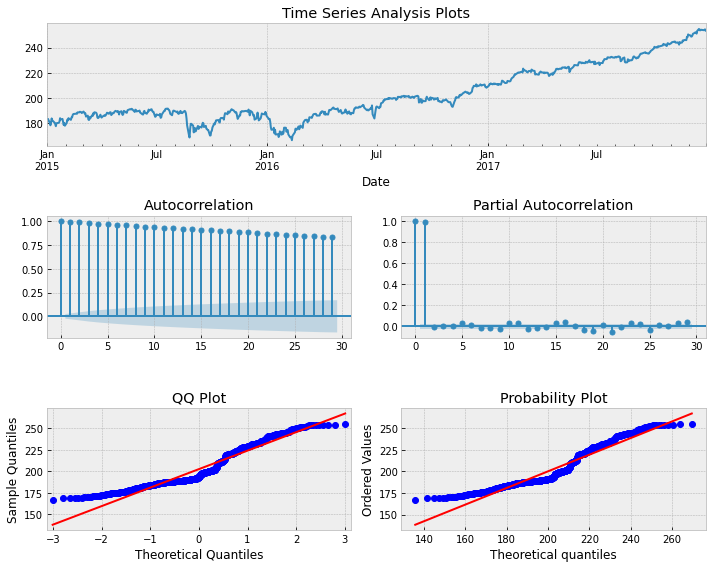

In [19]:
tsplot(spy_p)

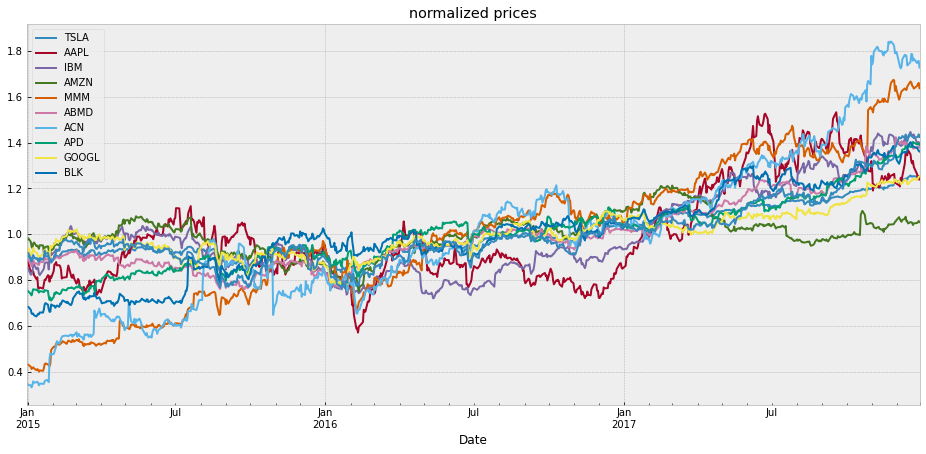

In [20]:
plt.figure(figsize=(16,7))
(spy_p / spy_p.mean()).plot()
for _, data in rp_df.iteritems():
    (data / data.mean()).plot()
plt.title("normalized prices")
plt.legend(tickers)
plt.show()

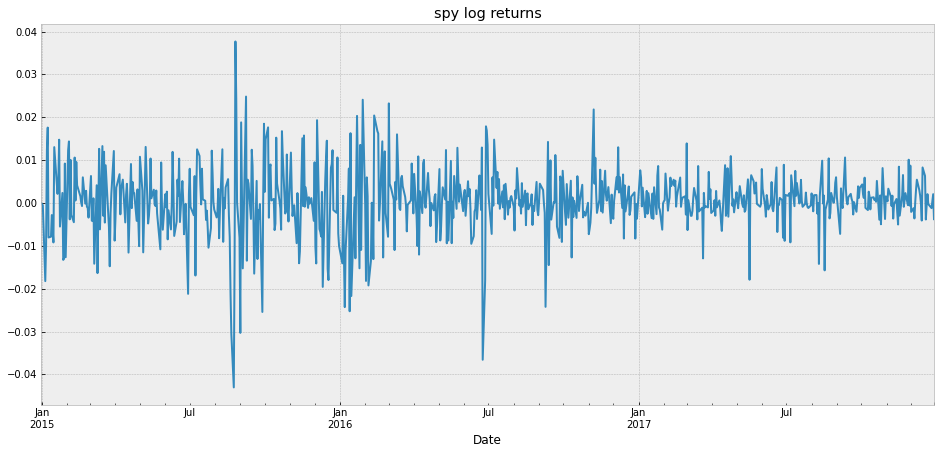

In [21]:
spy = raw_adj_close_log_returns(spy_p)
plt.figure(figsize=(16,7))
spy.plot()
plt.title("spy log returns")
plt.show()

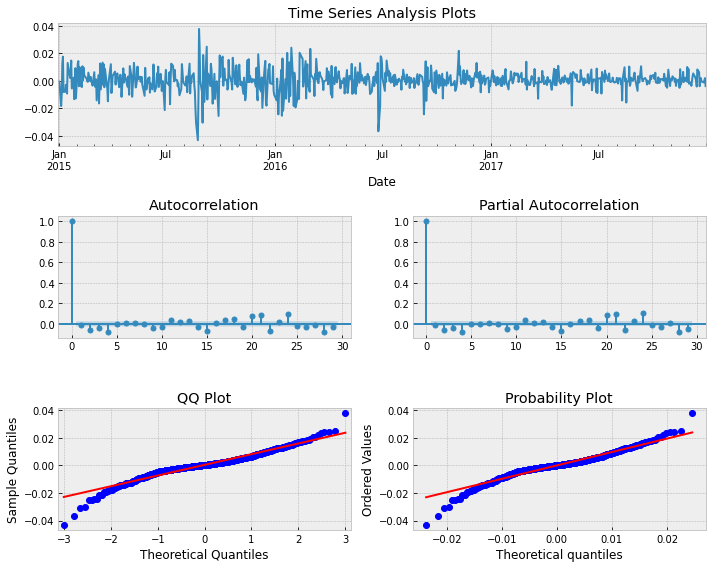

In [22]:
tsplot(spy)

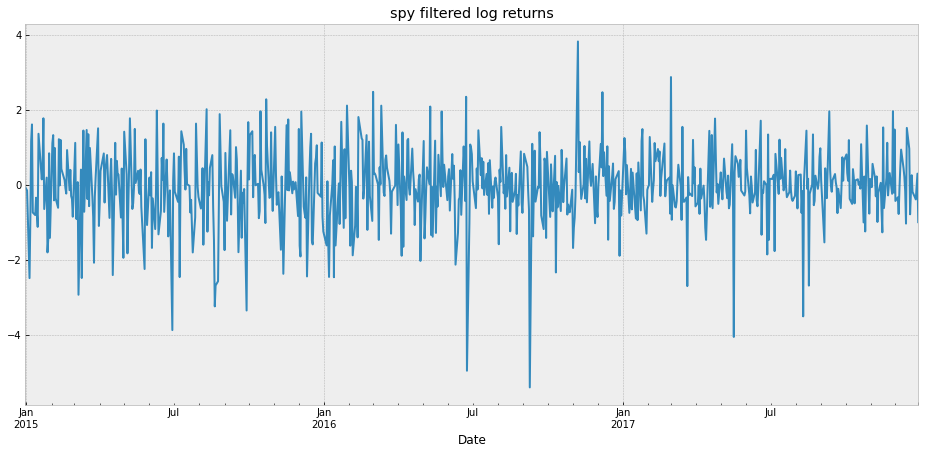

In [23]:
spyf, spy_means, spy_vars = arch_filtered_series(spy, lag=GARCH_LAG, forecast_horizon=GARCH_REFIT_DELAY_DAYS,
                                                mean=MEAN_MODEL, vol=VOL_MODEL, dist=DISTRIBUTION_,
                                                p=p_, o=o_, q=q_)
plt.figure(figsize=(16,7))
spyf.plot()
plt.title("spy filtered log returns")
plt.show()

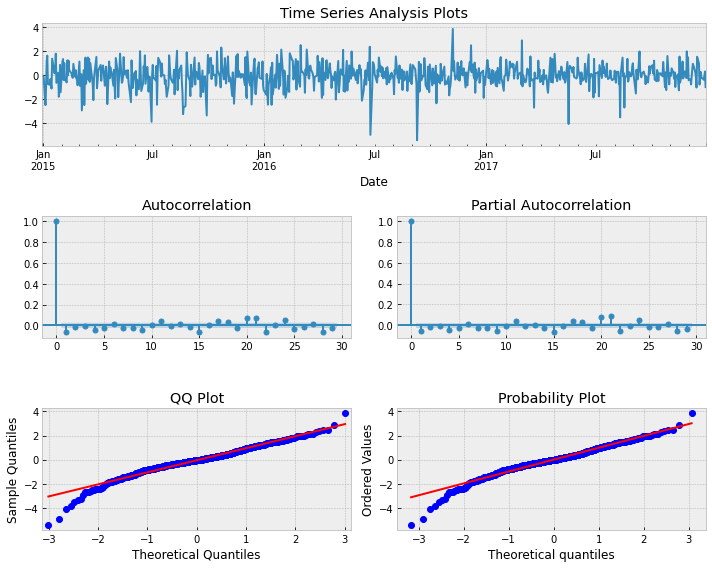

In [24]:
tsplot(spyf)

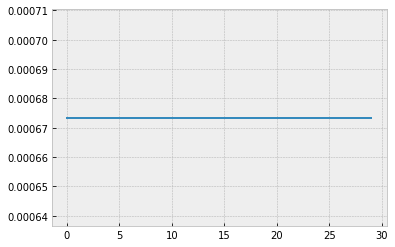

In [25]:
spy_means.plot()
plt.show()

In [26]:
res = spy_p.values
result = adfuller(res)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
res = spy.values
result = adfuller(res)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
res = spyf.dropna().values
result = adfuller(res)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.354182
p-value: 0.979698
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
ADF Statistic: -15.920028
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
ADF Statistic: -29.103844
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


In [27]:
mkt_returns = {}
for ticker, data in rp_df.iteritems():
    mkt_returns[ticker] = raw_adj_close_log_returns(data)

In [28]:
# %%time
# aics = {}
# pars = {}
# aic, params = _find_best_model_params(spy)
# aics['SPY'] = aic
# pars['SPY'] = params

In [29]:
# for ticker in tickers:
#    aic, params = _find_best_model_params(mkt_returns[ticker])
#    aics[ticker] = aic
#    pars[ticker] = params

In [30]:
%%time
betas = {}
if BETA_TYPE == BetaType.NO:
    for ticker in tickers:
        betas[ticker] = 0
elif BETA_TYPE == BetaType.RAW:
    for ticker, data in raw_prices.items():
        betas[ticker] = beta(spy_p, data, lag=BETA_LAG)
elif BETA_TYPE == BetaType.RETURNS:
    for ticker, data in mkt_returns.items():
        betas[ticker] = beta(spy, data, lag=BETA_LAG)
elif BETA_TYPE == BetaType.FILTERED:
    filtered_returns = {}
    for ticker, net_rets in mkt_returns.items():
        fltr_res, _, _ = arch_filtered_series(net_rets, lag=GARCH_LAG, forecast_horizon=GARCH_REFIT_DELAY_DAYS,
                                              mean=MEAN_MODEL, vol=VOL_MODEL, dist=DISTRIBUTION_, 
                                              p=p_, o=o_, q=q_)
        filtered_returns[ticker] = fltr_res[GARCH_LAG:]
    for ticker, data in filtered_returns.items():
        betas[ticker] = beta(spyf, data, lag=BETA_LAG)
betas

CPU times: user 3.82 s, sys: 3.33 s, total: 7.15 s
Wall time: 1.09 s


{'TSLA': 0.2702276796528265,
 'AAPL': 0.40745667378163924,
 'IBM': 0.36777664996821097,
 'AMZN': 0.36144112226299696,
 'MMM': 0.4158943279883575,
 'ABMD': 0.31817526883719954,
 'ACN': 0.4650625806560315,
 'APD': 0.45425483336461214,
 'GOOGL': 0.4440756595553552,
 'BLK': 0.5880453287848231}

In [31]:
net_market_returns = {}
for ticker, data in mkt_returns.items():
    net_market_returns[ticker] = data - spy * betas[ticker]
    
nmkt_rets_df = pd.DataFrame(net_market_returns, columns=tickers)
nmkt_rets_df



,TSLA,AAPL,IBM,AMZN,MMM,ABMD,ACN,APD,GOOGL,BLK
Date,,,,,,,,,,
2014-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-01-02,-0.013892,-0.009340,0.010244,-0.005721,-0.001361,-0.019732,-0.005027,0.008529,-0.001856,-0.002009
2015-01-05,-0.038025,-0.021150,-0.009157,-0.014144,-0.015231,-0.000655,-0.008553,-0.024218,-0.011145,-0.015498
2015-01-06,0.008206,0.003950,-0.018321,-0.019677,-0.006785,-0.022673,-0.002838,0.003944,-0.020787,-0.010096
2015-01-07,-0.004910,0.008879,-0.011111,0.006068,0.002072,0.027393,0.015013,0.005117,-0.008445,0.013660
...,...,...,...,...,...,...,...,...,...,...
2017-12-22,-0.019599,0.000107,0.006675,-0.005368,-0.000104,0.005367,-0.001891,0.001711,-0.001744,-0.002713
2017-12-26,-0.024301,-0.025209,0.002602,0.007597,0.003561,-0.010638,-0.005309,-0.002030,-0.002288,0.003823
2017-12-27,-0.018099,-0.000022,0.001782,0.004487,0.002978,0.004477,0.001928,0.003881,-0.005531,0.000881


In [32]:
%%time
today = 2 * GARCH_LAG + 1
nmkt_retsf_df, means_df, vars_df = get_filtered_data(nmkt_rets_df[(today - 2 * GARCH_LAG - 1): today])#fixme check

CPU times: user 2.99 s, sys: 2.79 s, total: 5.79 s
Wall time: 995 ms


In [33]:
corr_matrix = nmkt_retsf_df.corr(min_periods=CORRELATION_MATRIX_LAG)

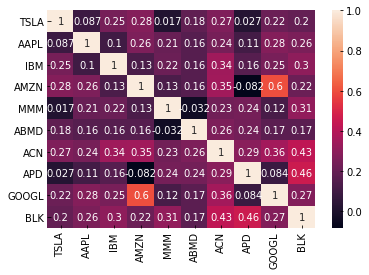

In [34]:
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [95]:
def trade(alphas, positions, prices, i):
    new_positions = pd.DataFrame({}, columns=tickers, index=[0])
    cash = positions.iloc[0]['CASH']
    if cash < 0:
        print("Negative cash! Bankrupt! ", cash, " @ ", i)
        print(alphas)
        print('=======================================================')
        print(positions)
        print('=======================================================')
        print(prices)
    pv_ = cash
    for ticker in tickers:
        pv_ = pv_ + positions.iloc[0][ticker] * prices[ticker]
    expected_positions = alphas.iloc[0] * pv_
    max_pos = pv_ * MAX_POSITION_PER_EQUITY
    max_trade = pv_ * MAX_POSITION_PER_EQUITY_PER_TRADE
    for ticker in tickers:
        expected_positions[ticker] = min(expected_positions[ticker], max_pos)
    for ticker in tickers:
        amount_to_buy = expected_positions[ticker] - positions.iloc[0][ticker] * prices[ticker]
        if abs(amount_to_buy) > max_trade:
            amount_to_buy = math.copysign(max_trade, amount_to_buy)
        cash = cash - amount_to_buy - abs(amount_to_buy) * FEE
        new_positions[ticker] = positions.iloc[0][ticker] + amount_to_buy / prices[ticker]
    new_positions['CASH'] = cash    
    return pv_, new_positions
    

In [56]:
raw_prices['AAPL']

Date
2014-12-31    25.181044
2015-01-02    24.941502
2015-01-05    24.238857
2015-01-06    24.241146
2015-01-07    24.581060
                ...    
2017-12-22    42.176311
2017-12-26    41.106304
2017-12-27    41.113533
2017-12-28    41.229214
2017-12-29    40.783367
Freq: D, Name: Adj Close, Length: 756, dtype: float64

In [96]:
%%time
init_positions = {}
for ticker in tickers:
    init_positions[ticker] = 0
init_positions['CASH'] = INITIAL_CASH
positions = pd.DataFrame(init_positions, index=[0])

pv_series = [INITIAL_CASH]
last_refit_date = GARCH_LAG * 2 + 1
while last_refit_date < len(rp_df):
    nmkt_retsf_df, means_df, vars_df = get_filtered_data(nmkt_rets_df[: last_refit_date])#fixme check
    corr_matrix = nmkt_retsf_df.corr(min_periods=CORRELATION_MATRIX_LAG)
    for offset in range(0, GARCH_REFIT_DELAY_DAYS):
        today = min(last_refit_date + offset + 1, len(nmkt_rets_df) - 1)
        alphas = calc_alphas(nmkt_rets_df.iloc[today], corr_matrix, means_df.iloc[offset], vars_df.iloc[offset])
        alphas_array = alphas.to_numpy()
        alpha_norma = max(max(alphas_array[0]), -min(alphas_array[0]))
        normalized_alphas = (alphas / alpha_norma / 100 * MAX_POSITION_PER_EQUITY)
        pv, new_positions = trade(normalized_alphas, positions.tail(1), rp_df.iloc[today], today)
        pv_series.append(pv)
        positions = positions.append(new_positions, ignore_index=True)
    last_refit_date = last_refit_date + GARCH_REFIT_DELAY_DAYS

CPU times: user 1min 14s, sys: 1min 12s, total: 2min 26s
Wall time: 19.4 s


7.575886765350791

In [97]:
positions

,TSLA,AAPL,IBM,AMZN,MMM,ABMD,ACN,APD,GOOGL,BLK,CASH
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,500000.000000
1,21.736295,4.349869,0.569753,0.996680,0.796383,3.195638,1.703176,2.559617,0.015970,-0.984130,497355.087002
2,-4.284958,-25.500389,-1.997862,-0.485182,-0.552839,-8.315011,1.296752,-1.639377,-0.054770,0.300676,502561.254334
3,-21.823913,-13.654127,-1.128598,-0.348853,-0.351367,-0.746166,1.674048,-3.168838,-0.150050,0.595526,501998.669459
4,22.156254,21.813652,-1.712043,0.249621,-2.127709,-6.158506,-2.660460,-2.963280,-0.226731,1.654993,499818.618739
...,...,...,...,...,...,...,...,...,...,...,...
356,-9.126245,9.068124,-0.374559,-0.851687,-0.225159,3.663754,-0.125897,-4.271506,-0.455081,0.672226,499454.487657
357,-8.886048,9.145535,-0.370853,-0.851686,-0.224112,3.596507,-0.109164,-4.243952,-0.453060,0.673927,499438.560453
358,-7.927135,8.247961,-0.323942,-0.851686,-0.195685,3.279221,-0.091470,-3.810885,-0.394661,0.600591,499366.108390
359,-7.718770,8.289203,-0.319843,-0.851685,-0.194204,3.220211,-0.078065,-3.780007,-0.391755,0.600337,499351.927299


<AxesSubplot:xlabel='Date'>

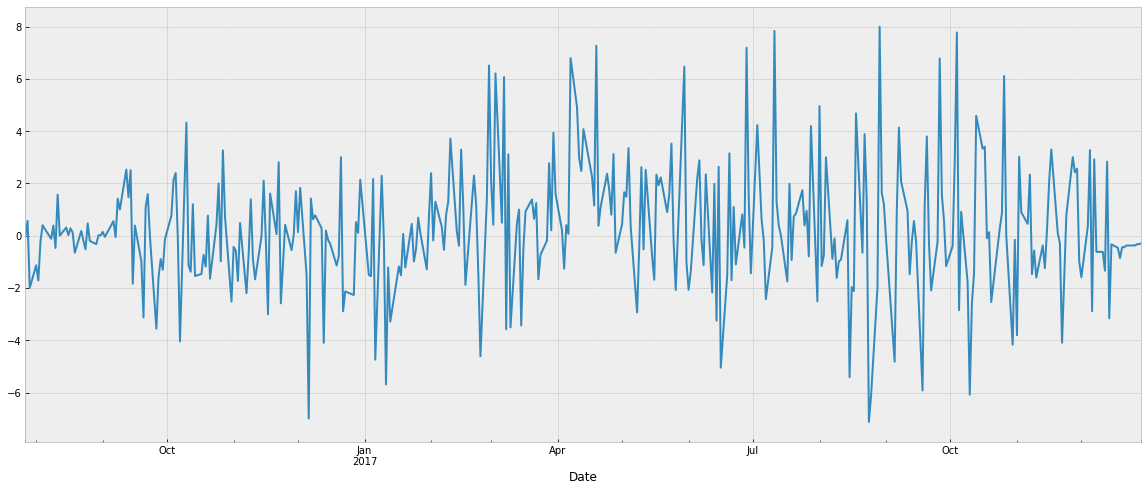

In [98]:
positions.index = spy_p.index[-len(positions):]
plt.figure(figsize=(20, 8))
positions['IBM'].plot()

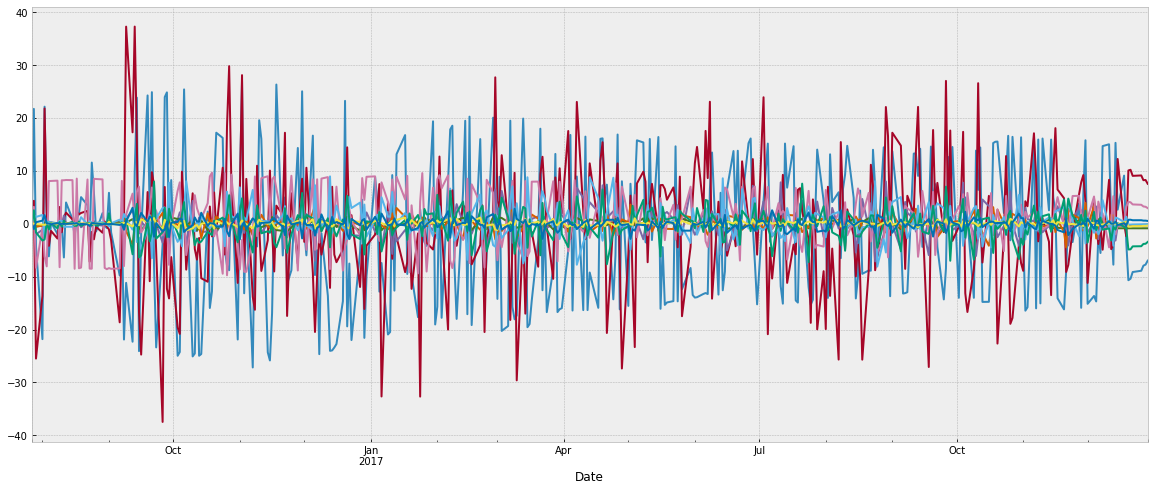

In [113]:
plt.figure(figsize=(20, 8))
for ticker in tickers:
    positions[ticker].plot()

<AxesSubplot:xlabel='Date'>

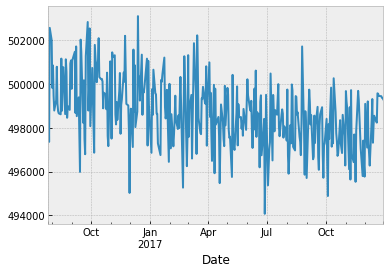

In [114]:
positions['CASH'].plot()

<AxesSubplot:xlabel='Date'>

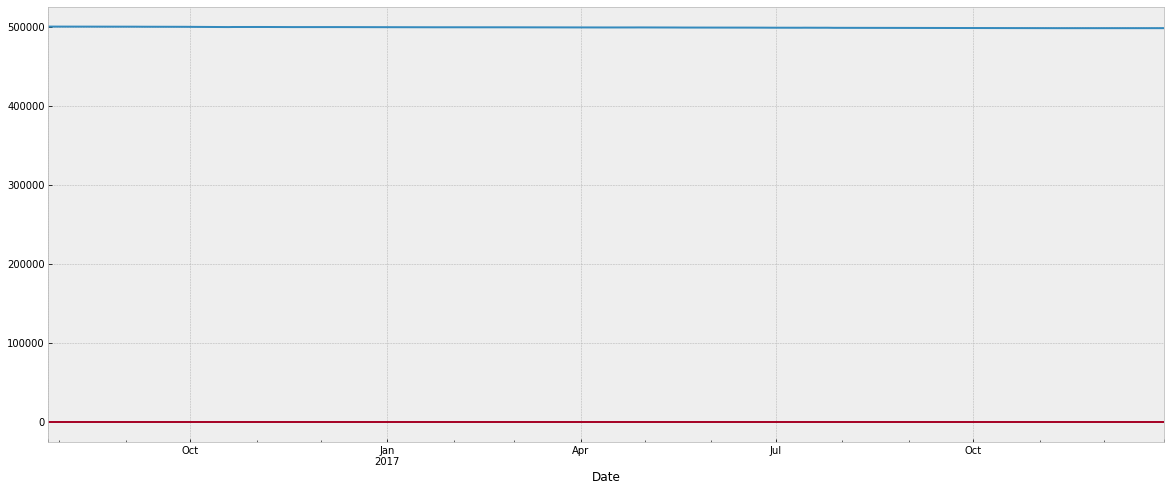

In [111]:
pv_s = pd.Series(pv_series)
pv_s.index = spy_p.index[-len(positions):]
plt.figure(figsize=(20, 8))
(pv_s / pv_s.mean()).plot()
(spy_p[-len(positions):] / spy_p[-len(positions):].mean()).plot()

<AxesSubplot:xlabel='Date'>

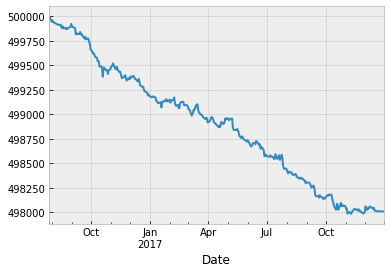

In [112]:
pv_s.plot()

In [102]:
pv_s[-1:]

360    498010.25826
dtype: float64

<AxesSubplot:xlabel='Date'>

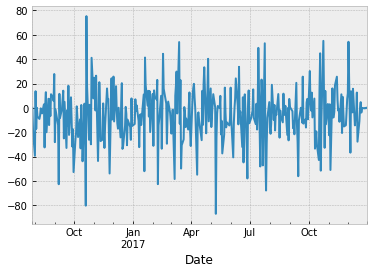

In [105]:
pnl = pv_s.diff()
pnl.plot()

In [106]:
pnl.min() / INITIAL_CASH

-0.00017415788859524763

In [107]:
beta(spy[-len(pnl):], pnl)

-0.5473221614494028

In [109]:
beta(spy_p[-len(pv_s):], pv_s)

-317.9933801508448

In [110]:
pnl.mean() / pnl.std()

-0.2526167219945726